In [5]:
# Binomial Model vs Black-Scholes
# Mohamed Ametti - Projet quantitatif

# --- Import des bibliothèques ---
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.stats import norm   # pour la CDF de la loi normale

In [7]:
def binomial_price(S0, K, r, sigma, T, n, is_call=True):
    """
    Calcule le prix d'une option européenne (call ou put) 
    avec le modèle binomial à n périodes.
    """
    # 1. paramètres par période
    rn = r * T / n
    u = (1 + rn) * np.exp(sigma * np.sqrt(T / n))
    d = (1 + rn) * np.exp(-sigma * np.sqrt(T / n))
    q = (1 + rn - d) / (u - d)
    disc = 1 / (1 + rn)

    # 2. prix du sous-jacent à maturité
    ST = np.zeros(n+1)
    ST[0] = S0 * d**n
    ratio = u/d
    for j in range(1, n+1):
        ST[j] = ST[j-1] * ratio

    # 3. payoffs
    if is_call:
        value = np.maximum(ST - K, 0)
    else:
        value = np.maximum(K - ST, 0)

    # 4. backward induction
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            value[j] = disc * ( q * value[j+1] + (1-q) * value[j] )

    return value[0]

In [9]:
def black_scholes_price(S0, K, r, sigma, T, is_call=True):
    """
    Prix Black-Scholes d'une option européenne (call/put).
    """
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if is_call:
        return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)


In [15]:
# Paramètres de base
S0 = 100      # prix initial
K = 100       # strike
r = 0.05      # taux sans risque (continu annualisé)
sigma = 0.2   # volatilité
T = 1.0       # maturité (1 an)

n = 100       # nombre de pas pour le modèle binomial


In [17]:
# Exemple : Call européen
for n in [5, 50, 200, 1000]:
    print(f"n={n}, Binomial={binomial_price(S0,K,r,sigma,T,n,True):.4f}")

bs_call = black_scholes_price(S0,K,r,sigma,T,True)
print(f"Black-Scholes Call = {bs_call:.4f}")


n=5, Binomial=10.5922
n=50, Binomial=10.4423
n=200, Binomial=10.4541
n=1000, Binomial=10.4493
Black-Scholes Call = 10.4506


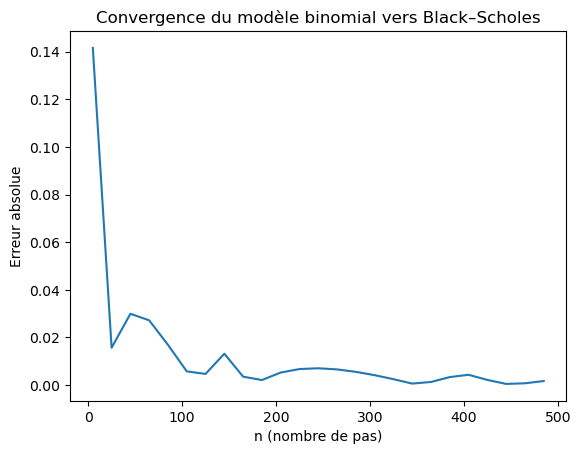

In [19]:
N_values = np.arange(5, 500, 20)
errors = [abs(binomial_price(S0,K,r,sigma,T,n,True) - bs_call) for n in N_values]

plt.plot(N_values, errors)
plt.xlabel("n (nombre de pas)")
plt.ylabel("Erreur absolue")
plt.title("Convergence du modèle binomial vers Black–Scholes")
plt.show()

In [ ]:
M = 10000   # nombre de trajectoires simulées
n = 500     # nombre de pas
rn = r*T/n
u = (1+rn)*np.exp(sigma*np.sqrt(T/n))
d = (1+rn)*np.exp(-sigma*np.sqrt(T/n))
q = (1+rn - d)/(u - d)

# Simulation via loi binomiale
k = np.random.binomial(n, q, size=M)   # nb de mouvements "up"
ST = S0 * (u**k) * (d**(n-k))

logST = np.log(ST)

# Histogramme comparé à une loi normale
mu = (r - 0.5*sigma**2)*T + log(S0)
var = sigma**2 * T

plt.hist(logST, bins=50, density=True, alpha=0.6, label="Simulé (Binomial)")
x = np.linspace(min(logST), max(logST), 200)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mu)**2/(2*var)), 'r-', label="Normal théorique")
plt.legend()
plt.title("Convergence de log(S_T) vers une loi normale")
plt.show()
